In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium, json

# **Initial data loading and analysis**

In [ ]:
data = pd.read_csv("../Data/raw/weather/weather.csv")
#loads the data

In [ ]:
rows = len(data.axes[0])
cols = len(data.axes[1])
  
# Print the number of rows and columns
print("Number of Rows: " + str(rows))
print("Number of Columns: " + str(cols))

In [ ]:
# make a sanity check: are there missing values anywhere in the weather data?
data.isnull().any()

In [ ]:
is_DE = data[data['iso3166-2'].str.startswith('DE')]
is_DE
#takes only Germany

In [ ]:
weather_by_region = is_DE.groupby(by="iso3166-2").agg(["min","mean","median","max"])
weather_by_region

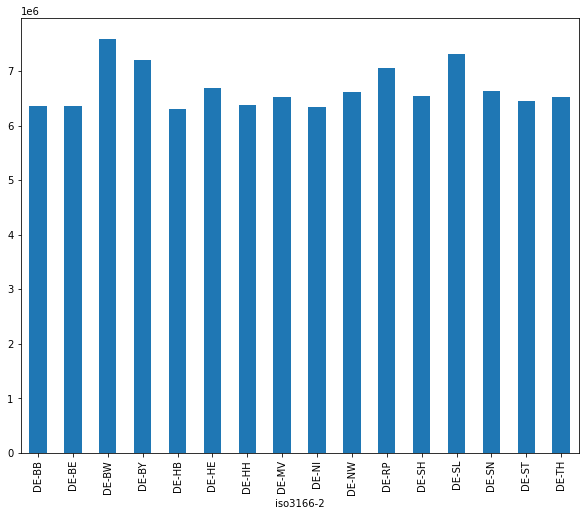

In [60]:
weather_by_region["SolarRadiation"]["mean"].plot.bar(figsize=(10,8));

In [ ]:
date_agg = is_DE.groupby(by="date").agg(["mean"])
date_agg

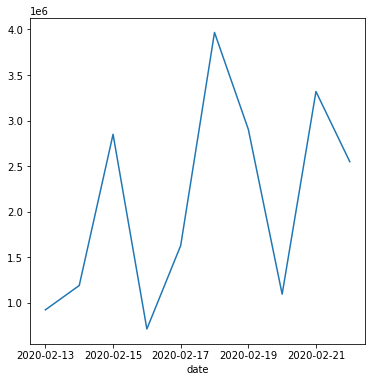

In [54]:
date_agg["SolarRadiation"]["mean"][:10].plot.line(figsize=(6,6));

# **Folium data analysis**

In [ ]:
#Initialize a folium map centered on your country of study
geo_json_path='../data/raw/shapefiles/de.geojson'
corona_df=pd.read_csv('../data/raw/corona/de_corona.csv',sep='\t')
with open('../data/raw/metadata/de_metadata.json','r', encoding="utf8") as f:
    country_metadata=json.load(f)
a=folium.Map(location=[51.1657,10.4515],zoom_start=6,crs='EPSG3857', 
    zoom_control=False, scrollWheelZoom=False,dragging=False)

#Adding the geodata and a layercontrol to the map
folium.GeoJson(geo_json_path, name = "geojson").add_to(a)
folium.LayerControl().add_to(a)
a

In [ ]:
#Defining the region map as dictionary that converts the "full name" of the regions to their respective iso code
region_map = {country_metadata["country_metadata"][i]["covid_region_code"]: 
    country_metadata["country_metadata"][i]["iso3166-2_code"] for i in range(len(country_metadata["country_metadata"]))}

#Creating a corona dataframe
corona_df["region"] = corona_df["region_code"].map(region_map)
corona_df

#Creating a corona dataframe and grouping by region
corona_df_by_region = corona_df.groupby(by = "region" ) ["confirmed_addition"].sum().reset_index()

#Defining a population map as a dictionary to convert the "full name" of the region to their iso code
population_map = {country_metadata["country_metadata"][i]["iso3166-2_code"]: 
    country_metadata["country_metadata"][i]["population"] for i in range(len(country_metadata["country_metadata"]))}

#Adding the population to the corona by region dataframe
corona_df_by_region["population"] = corona_df_by_region["region"].map(population_map)

corona_df_by_region

In [ ]:
a_cases = folium.Map(location=[51.1657, 10.4515],zoom_start=6,crs='EPSG3857',
    zoom_control=False, scrollWheelZoom=False,dragging=False)

folium.Choropleth(
    geo_data = geo_json_path,
    name = "cases",
    data = corona_df_by_region,
    columns = ["region", "confirmed_addition"],
    key_on = "properties.iso_3166_2",
    fill_color ="OrRd",
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = "Confirmed cases"
).add_to(a_cases)

a_cases

In [ ]:
a_pop = folium.Map(location=[51.1657, 10.4515],zoom_start=6,crs='EPSG3857', 
    zoom_control=False, scrollWheelZoom=False,dragging=False)

folium.Choropleth(
    geo_data = geo_json_path,
    name = "population",
    data = corona_df_by_region,
    columns = ["region", "population"],
    key_on = "properties.iso_3166_2",
    fill_color ="YlGn",
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = "Population"
).add_to(a_pop)

a_pop


In [ ]:
corona_df_by_region["confirmed_pc"] = corona_df_by_region["confirmed_addition"] / corona_df_by_region["population"]


a_cases_pc = folium.Map(location = [51.1657,10.4515], zoom_start = 6, crs = 'EPSG3857',
    zoom_control = False, scrollWheelZoom = False , dragging = False)


folium.Choropleth(
    geo_data = geo_json_path,
    name = "population",
    data = corona_df_by_region,
    columns = ["region", "confirmed_pc"],
    key_on = "properties.iso_3166_2",
    fill_color ="OrRd",
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = "Confirmed cases per capita"
).add_to(a_cases_pc)

a_cases_pc